In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
!pip install lmfit
import numpy as np
import pandas as pd
import seaborn as sns
import math
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_error
import lmfit
from tqdm.auto import tqdm
import pickle
import joblib
import matplotlib.dates as mdates
sns.set()
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_context("talk")
sns.set_style("ticks")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [59]:
df = pd.read_csv('/content/drive/MyDrive/Datascience/Project/daily_case.csv')
# dropping columns that are not used
df.drop(columns =['Sno', 'Time', 'State/UnionTerritory', 'ConfirmedIndianNational', 'ConfirmedForeignNational'], inplace = True)
df = df.groupby('Date', as_index =False).sum()
df['date'] = df['Date']

In [60]:
# finding cumulative infected, recovered, and deaths from the daily data
df['infected_per_day'] = df['Confirmed']
df['deaths_per_day'] = df['Deaths']
df['recovered_per_day'] = df['Cured']
df.drop(columns =['Confirmed', 'Deaths', 'Cured', 'Date'], inplace = True)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.sort_values(by='date')
df['total_infected'] = df['infected_per_day'].cumsum()
df['total_dead'] = df['deaths_per_day'].cumsum()
df['total_recovered'] = df['recovered_per_day'].cumsum()
df.reset_index()
df

,date,infected_per_day,deaths_per_day,recovered_per_day,total_infected,total_dead,total_recovered
0,2020-01-30,1,0,0,1,0,0
1,2020-01-31,1,0,0,2,0,0
2,2020-02-01,2,0,0,4,0,0
3,2020-02-02,3,0,0,7,0,0
4,2020-02-03,3,0,0,10,0,0
...,...,...,...,...,...,...,...
555,2021-08-07,31895385,427371,31055861,5323739609,71674973,4921484275
556,2021-08-08,31934455,427862,31099771,5355674064,72102835,4952584046
557,2021-08-09,31969954,428309,31139457,5387644018,72531144,4983723503
558,2021-08-10,31998158,428682,31180968,5419642176,72959826,5014904471


In [61]:
assert (pd.date_range(start=df.date.iloc[0], end=df.date.iloc[-1], freq='D') == df.date).all()

In [62]:
df.index = pd.date_range(start=df.date.iloc[0], end=df.date.iloc[-1], freq='D')
df.index 

DatetimeIndex(['2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08',
               ...
               '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05',
               '2021-08-06', '2021-08-07', '2021-08-08', '2021-08-09',
               '2021-08-10', '2021-08-11'],
              dtype='datetime64[ns]', length=560, freq='D')

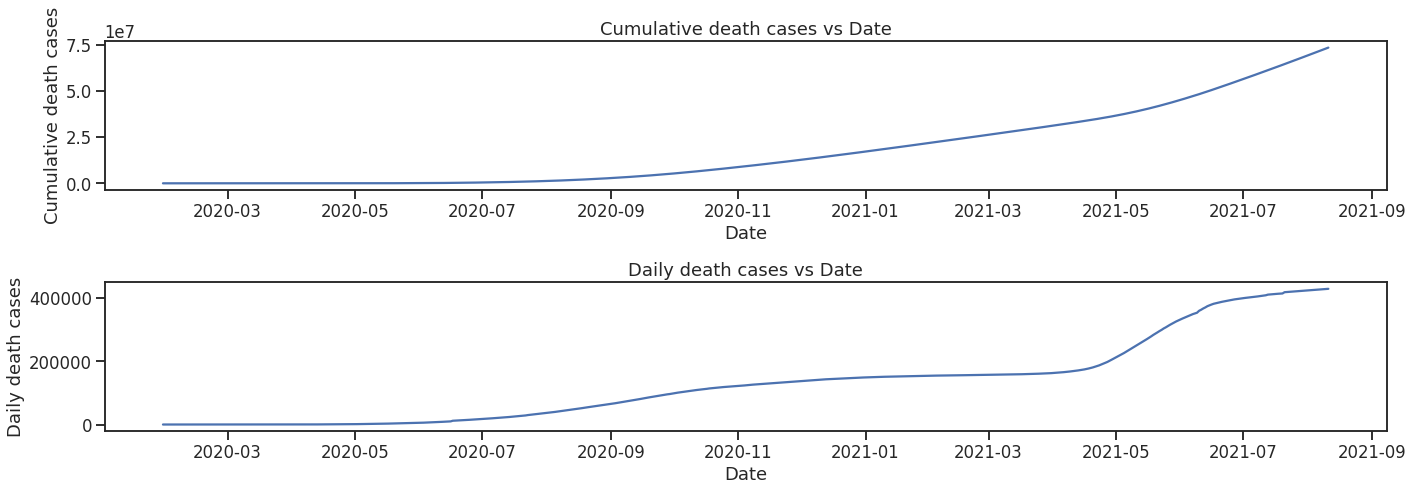

In [63]:
fig = plt.figure(figsize=(20,7))
ax1 = plt.subplot(2, 1, 1)
# df.total_infected.plot()
plt.plot(df.index, df.total_dead.values)
plt.title("Cumulative death cases vs Date")
plt.xlabel("Date")
plt.ylabel("Cumulative death cases")
plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(df.index, df.deaths_per_day.values)
plt.title("Daily death cases vs Date")
plt.xlabel("Date")
plt.ylabel("Daily death cases")
plt.tight_layout()
# plt.savefig('figures/habr/infected_overview.png')
plt.show()

In [64]:
# smoothing columns as data is usually added with some lag
df_smoothed = df.rolling(7).mean().round(5)
df_smoothed.columns = [col + '_ma7' for col in df_smoothed.columns]

full_df = pd.concat([df, df_smoothed], axis=1)

for column in full_df.columns:
    if column.endswith('_ma7'):
        original_column = column.strip('_ma7')
        full_df[column] = full_df[column].fillna(full_df[original_column])

In [65]:
df = full_df

In [66]:
from IPython.display import display, HTML

display(df)
# display(HTML(df.to_html()))

,date,infected_per_day,deaths_per_day,recovered_per_day,total_infected,total_dead,total_recovered,infected_per_day_ma7,deaths_per_day_ma7,recovered_per_day_ma7,total_infected_ma7,total_dead_ma7,total_recovered_ma7
2020-01-30,2020-01-30,1,0,0,1,0,0,1.000000e+00,0.00000,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
2020-01-31,2020-01-31,1,0,0,2,0,0,1.000000e+00,0.00000,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
2020-02-01,2020-02-01,2,0,0,4,0,0,2.000000e+00,0.00000,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
2020-02-02,2020-02-02,3,0,0,7,0,0,3.000000e+00,0.00000,0.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00
2020-02-03,2020-02-03,3,0,0,10,0,0,3.000000e+00,0.00000,0.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-07,2021-08-07,31895385,427371,31055861,5323739609,71674973,4921484275,3.177310e+07,425784.42857,3.093626e+07,5.228259e+09,7.039560e+07,4.828518e+09
2021-08-08,2021-08-08,31934455,427862,31099771,5355674064,72102835,4952584046,3.181290e+07,426286.00000,3.097615e+07,5.260072e+09,7.082189e+07,4.859494e+09
2021-08-09,2021-08-09,31969954,428309,31139457,5387644018,72531144,4983723503,3.185204e+07,426791.14286,3.101644e+07,5.291924e+09,7.124868e+07,4.890511e+09
2021-08-10,2021-08-10,31998158,428682,31180968,5419642176,72959826,5014904471,3.189085e+07,427289.28571,3.105710e+07,5.323815e+09,7.167597e+07,4.921568e+09


In [11]:
# BEFORE_DELTA = '2021-01-10'

In [67]:
# train_subset = df[df['date'] < BEFORE_DELTA]
train_subset = df

# Classic SEIRD

In [68]:
class BarebonesSEIR:
    def __init__(self, params=None):
        self.params = params

    def get_fit_params(self):
        params = lmfit.Parameters()
        params.add("population", value=1_38_00_00_000, vary=False)
        params.add("epidemic_started_days_ago", value=10, vary=False)
        params.add("r0", value=4, min=3, max=5, vary=True)
        params.add("alpha", value=0.097, min=0.067, max=0.140, vary=True)  # CFR
        params.add("delta", value=1/3, min=1/14, max=1/2, vary=True)  # E -> I rate
        params.add("gamma", value=1/9, min=1/14, max=1/7, vary=True)  # I -> R rate
        params.add("rho", expr='gamma', vary=False)  # I -> D rate
        return params

    def get_initial_conditions(self, data):
        # Simulate such initial params as to obtain as many deaths as in data
        population = self.params['population']
        epidemic_started_days_ago = self.params['epidemic_started_days_ago']

        t = np.arange(epidemic_started_days_ago)
        (S, E, I, R, D) = self.predict(t, (population - 1, 0, 1, 0, 0))

        I0 = I[-1]
        E0 = E[-1]
        Rec0 = R[-1]
        D0 = D[-1]
        S0 = S[-1]
        return (S0, E0, I0, Rec0, D0)

    def step(self, initial_conditions, t):
        population = self.params['population']
        delta = self.params['delta']
        gamma = self.params['gamma']
        alpha = self.params['alpha']
        rho = self.params['rho']
        
        rt = self.params['r0'].value
        beta = rt * gamma

        S, E, I, R, D = initial_conditions

        new_exposed = beta * I * (S / population)
        new_infected = delta * E
        new_dead = alpha * rho * I
        new_recovered = gamma * (1 - alpha) * I

        dSdt = -new_exposed
        dEdt = new_exposed - new_infected
        dIdt = new_infected - new_recovered - new_dead
        dRdt = new_recovered
        dDdt = new_dead

        assert S + E + I + R + D - population <= 1e10
        assert dSdt + dIdt + dEdt + dRdt + dDdt <= 1e10
        return dSdt, dEdt, dIdt, dRdt, dDdt

    def predict(self, t_range, initial_conditions):
        ret = odeint(self.step, initial_conditions, t_range)
        return ret.T

In [69]:
model = BarebonesSEIR()
model.params = model.get_fit_params()
train_initial_conditions = model.get_initial_conditions(train_subset)
train_t = np.arange(len(train_subset))
(S, E, I, R, D) = model.predict(train_t, train_initial_conditions)

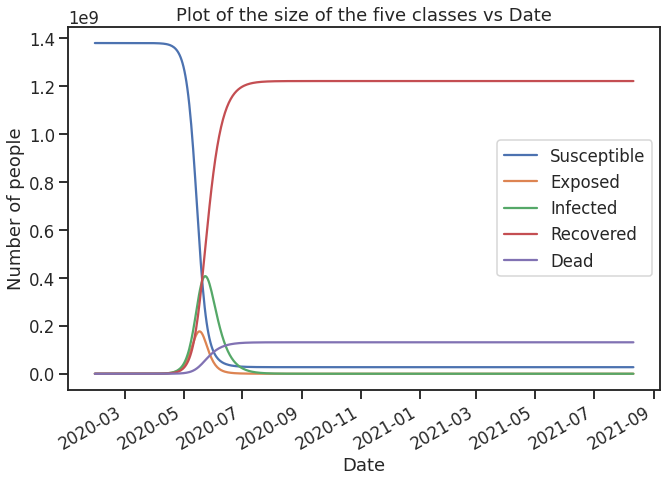

In [70]:
fig = plt.figure(figsize=(10,7))
plt.plot(train_subset.date, S, label='Susceptible')
plt.plot(train_subset.date, E, label='Exposed')
plt.plot(train_subset.date, I, label='Infected')
plt.plot(train_subset.date, R, label='Recovered')
plt.plot(train_subset.date, D, label='Dead')
plt.title("Plot of the size of the five classes vs Date")
plt.xlabel("Date")
plt.ylabel("Number of people")
plt.legend()
plt.tight_layout()
fig.autofmt_xdate()
plt.show()

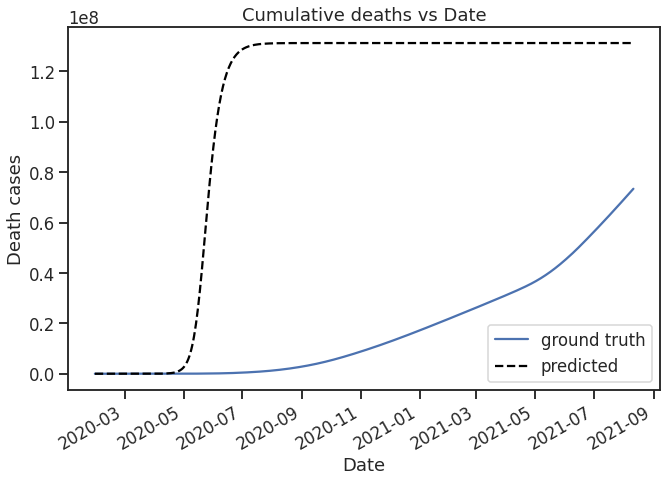

In [71]:
fig = plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted', color='black', linestyle='dashed' )
plt.legend()
plt.title('Cumulative deaths vs Date')
plt.xlabel("Date")
plt.ylabel("Death cases")
plt.tight_layout()
fig.autofmt_xdate()
plt.show()

# Qaurantine measures

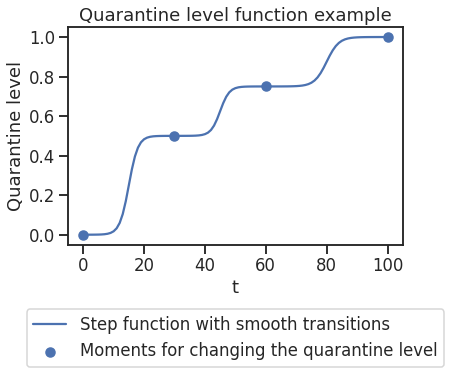

In [72]:
def sigmoid(x, xmin, xmax, a, b, c, r):
    x_scaled = (x - xmin) / (xmax - xmin)
    out = (a * np.exp(c * r) + b * np.exp(r * x_scaled)) / (np.exp(c * r) + np.exp(x_scaled * r))
    return out


def stepwise_soft(t, coefficients, r=20, c=0.5):
    t_arr = np.array(list(coefficients.keys()))

    min_index = np.min(t_arr)
    max_index = np.max(t_arr)

    if t <= min_index:
        return coefficients[min_index]
    elif t >= max_index:
        return coefficients[max_index]
    else:
        index = np.min(t_arr[t_arr >= t])

    if len(t_arr[t_arr < index]) == 0:
        return coefficients[index]
    prev_index = np.max(t_arr[t_arr < index])
    # sigmoid smoothing
    q0, q1 = coefficients[prev_index], coefficients[index]
    out = sigmoid(t, prev_index, index, q0, q1, c, r)
    return out

t_range = np.arange(100)
coefficients = {
    0: 0,
    30: 0.5,
    60: 0.75,
    100: 1,
}

plt.title('Quarantine level function example')
plt.scatter(coefficients.keys(), coefficients.values(), label='Moments for changing the quarantine level')
plt.plot(t_range, [stepwise_soft(t, coefficients, r=20, c=0.5) for t in t_range], label='Step function with smooth transitions')
plt.xlabel('t')
plt.ylabel('Quarantine level')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6),)
plt.show()

# Train SEIRD + hidden/visible groups + quarantine

In [73]:
%cd /content/drive/MyDrive/Datascience/Project

/content/drive/.shortcut-targets-by-id/1KZzv75J0k47wxZV1VfqtQ0m5jJYCSUXn/Datascience/Project


In [74]:
from sir_models.fitters import HiddenCurveFitter
from sir_models.models import SEIRHidden

In [75]:
stepwize_size = 60

weights = {
    'I': 0.25,
    'R': 0.25,
    'D': 0.5,
}
weights = None
model = SEIRHidden(stepwise_size=stepwize_size)
fitter = HiddenCurveFitter(
     new_deaths_col='deaths_per_day_ma7',
     new_cases_col='infected_per_day_ma7',
     new_recoveries_col='recovered_per_day_ma7',
     
     weights=weights,
     max_iters=1000,
     save_params_every=50,
)
fitter.fit(model, train_subset)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [76]:
result = fitter.result
result

In [77]:
train_initial_conditions = model.get_initial_conditions(train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, Iv, R, Rv, D, Dv), history = model.predict(train_t, train_initial_conditions)
(new_exposed,
new_infected_invisible, new_infected_visible,
new_recovered_invisible, new_recovered_visible,
new_dead_invisible, new_dead_visible) = model.compute_daily_values(S, E, I, Iv, R, Rv, D, Dv)

In [78]:
daily_df = pd.DataFrame(
    {
        'date': train_subset.date[1:].values,
        'new_exposed': new_exposed,
        'new_infected_invisible': new_infected_invisible,
        'new_infected_visible': new_infected_visible,
        'new_recovered_invisible': new_recovered_invisible,
        'new_recovered_visible': new_recovered_visible,
        'new_dead_invisible': new_dead_invisible,
        'new_dead_visible': new_dead_visible
    },
    index=train_subset.date[1:])

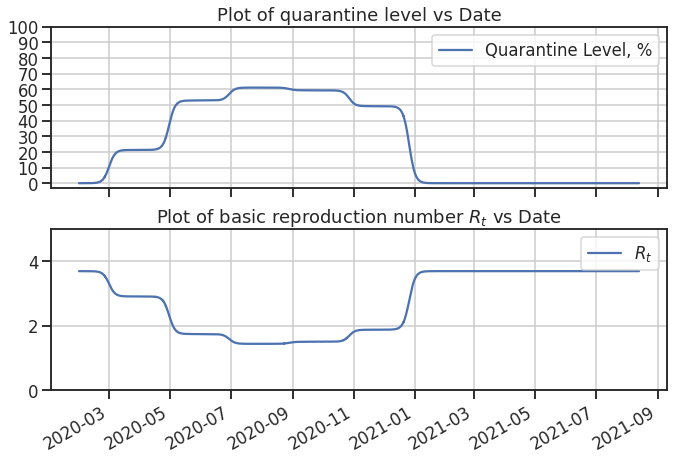

In [79]:
history_dates = df.date.iloc[0] + pd.to_timedelta(history.t, unit='days')

fig = plt.figure(figsize=(10, 7))
ax1 = plt.subplot(2,1,1)
plt.plot(history_dates, history.quarantine_mult, label='Quarantine Level, %')
plt.title('Plot of quarantine level vs Date')
plt.legend()
plt.tight_layout()
y_ticks = list(np.arange(0, 1.1, 0.1).round(1))
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels([f'{int(100*t)}' for t in y_ticks])
plt.grid()

plt.subplot(2,1,2, sharex=ax1)
plt.plot(history_dates, history.rt, label='$R_t$')
plt.title('Plot of basic reproduction number $R_t$ vs Date')
plt.ylim(0, 5)
plt.grid()
plt.legend()

fig.autofmt_xdate()
plt.show()

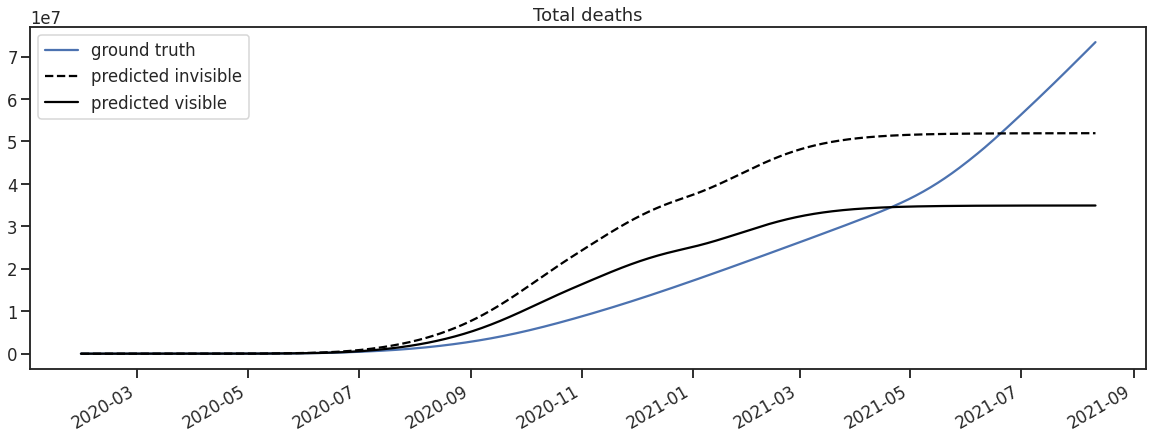

In [80]:
fig = plt.figure(figsize=(20, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted invisible', color='black', linestyle='dashed' )
plt.plot(train_subset.date, Dv, label='predicted visible', color='black')
plt.legend()
plt.title('Total deaths')
fig.autofmt_xdate()
plt.show()


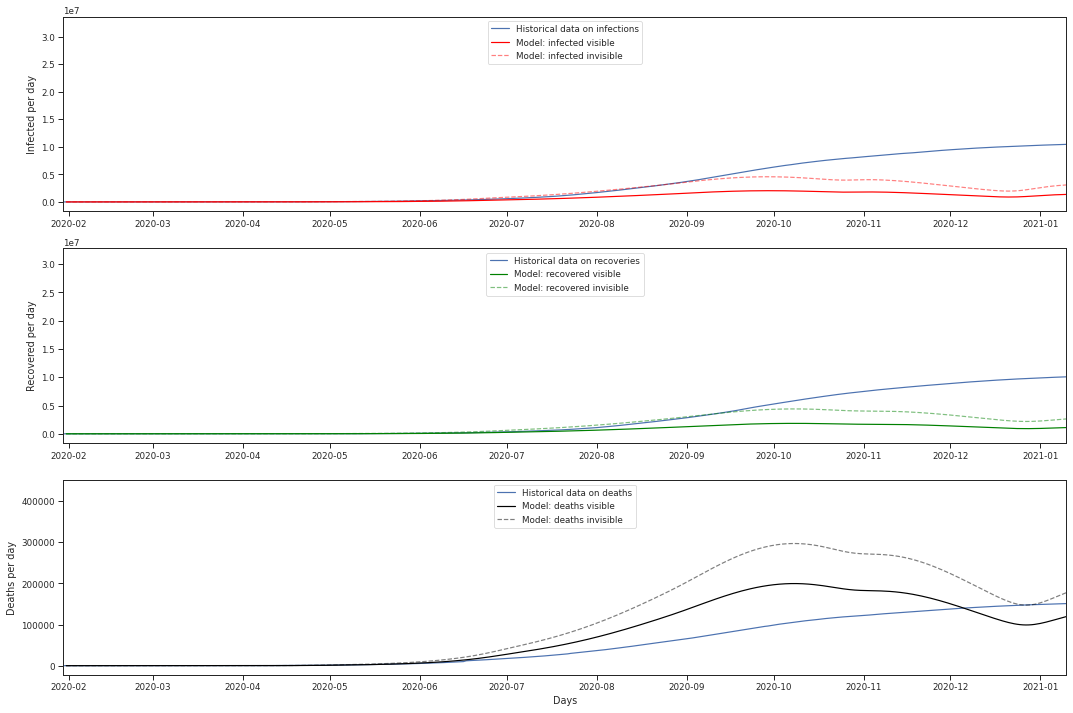

In [81]:
sns.set_context("paper")
sns.set_style("ticks")
plt.figure(figsize=(15, 10))

ax1 = plt.subplot(3, 1, 1)
plt.plot(train_subset.date, train_subset['infected_per_day'], label='Historical data on infections')
plt.plot(daily_df.new_infected_visible, label='Model: infected visible', color='red', )
plt.plot(daily_df.new_infected_invisible, label='Model: infected invisible', color='red', alpha=0.5, linestyle='dashed')
plt.legend(loc="upper center")
plt.ylabel('Infected per day')
plt.xlim(pd.to_datetime('2020-01-30	'), pd.to_datetime(BEFORE_DELTA))

plt.subplot(3, 1, 2, sharex=ax1)
plt.plot(train_subset.date, train_subset['recovered_per_day'], label='Historical data on recoveries')
plt.plot(daily_df.new_recovered_visible, label='Model: recovered visible', color='green', )
plt.plot(daily_df.new_recovered_invisible, label='Model: recovered invisible', color='green', alpha=0.5, linestyle='dashed')
plt.legend(loc="upper center")
plt.ylabel('Recovered per day')
plt.xlim(pd.to_datetime('2020-01-30	'), pd.to_datetime(BEFORE_DELTA))

plt.subplot(3, 1, 3, sharex=ax1)
plt.plot(train_subset.date, train_subset['deaths_per_day'], label='Historical data on deaths')
plt.plot(daily_df.new_dead_visible, label='Model: deaths visible', color='black', )
plt.plot(daily_df.new_dead_invisible, label='Model: deaths invisible', color='black', alpha=0.5, linestyle='dashed')
plt.legend(loc="upper center")
plt.ylabel('Deaths per day')
plt.xlim(pd.to_datetime('2020-01-30	'), pd.to_datetime(BEFORE_DELTA))
plt.xlabel('Days')

plt.tight_layout()
plt.show()

In [55]:
# plt.figure(figsize=(20, 10))
# plt.subplot(3, 1, 3, sharex=ax1)
# plt.plot(train_subset.date, train_subset['deaths_per_day'], label='Historical data on deaths')
# plt.plot(daily_df.new_dead_visible, label='Model: deaths visible', color='black', )
# plt.plot(daily_df.new_dead_invisible, label='Model: deaths invisible', color='black', alpha=0.5, linestyle='dashed')
# plt.legend(loc="upper center")
# plt.ylabel('Deaths per day')
# plt.xlim(pd.to_datetime('2020-01-30'), pd.to_datetime(BEFORE_DELTA))
# plt.xlabel('Date')
# plt.tight_layout()
# # plt.savefig('figures/paper/daily_infected_dead_recovered_train.png')
# plt.show()

In [56]:
%cd /content/drive/MyDrive/Datascience/Project

/content/drive/.shortcut-targets-by-id/1KZzv75J0k47wxZV1VfqtQ0m5jJYCSUXn/Datascience/Project


In [88]:
from sir_models.utils import eval_on_select_dates_and_k_days_ahead, smape

In [108]:
K = 30
last_day = df.date.iloc[-1] - pd.to_timedelta(K, unit='D')
eval_dates = pd.date_range(start='2020-03-01', end=last_day)[::20][-11:-1]
len(eval_dates)

10

In [110]:
def eval_hidden_india(train_df, t, train_t, eval_t):
    weights = {
        'I': 0.25,
        'R': 0.25,
        'D': 0.5,
    }
    model = SEIRHidden()
    fitter = HiddenCurveFitter(
        new_deaths_col='deaths_per_day_ma7',
        new_cases_col='infected_per_day_ma7',
        new_recoveries_col='recovered_per_day_ma7',
        weights=weights,
        max_iters=1000,
        save_params_every=500)
    fitter.fit(model, train_df)

    train_initial_conditions = model.get_initial_conditions(train_df)
    train_states, history = model.predict(train_t, train_initial_conditions, history=False)

    test_initial_conds = [compartment[-1] for compartment in train_states]
    test_states, history = model.predict(eval_t, test_initial_conds, history=False)
        
    return model, fitter, test_states

In [111]:
models, fitters, model_predictions, train_dfs, test_dfs = eval_on_select_dates_and_k_days_ahead(df,
                                                                                     eval_func=eval_hidden_india, 
                                                                                     eval_dates=eval_dates, 
                                                                                     k=K)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Reached max iters
Reached max iters


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Reached max iters
Reached max iters


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Reached max iters
Reached max iters


FileNotFoundError: ignored

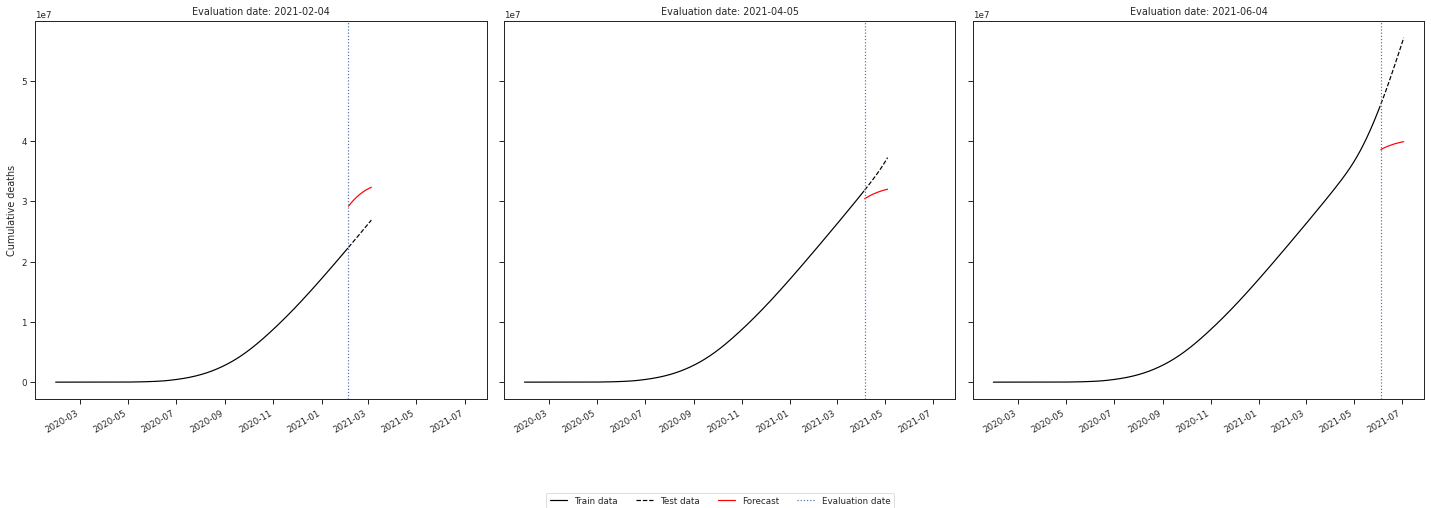

In [131]:
def plot_eval_result(ix, first=False):
    eval_date = eval_dates[ix]
    train_df = train_dfs[ix]
    test_df = test_dfs[ix]
    model_preds = model_predictions[ix]

    plt.plot(train_df.date, train_df.total_dead, label='Train data', color='black')
    plt.plot(test_df.date, test_df.total_dead, label='Test data', color='black', linestyle='dashed')
    plt.plot(test_df.date, model_preds[7], label='Forecast', color='red')
    plt.title(f'Evaluation date: {str(eval_date.date())}')
    plt.axvline(x=eval_date, linestyle='dotted', label='Evaluation date')
    if first:
        plt.ylabel('Cumulative deaths')
    else:
        plt.setp(plt.gca().get_yticklabels(), visible=False)

fig = plt.figure(figsize=(20, 7))

ax1 = plt.subplot(1, 3, 1)

ix = 3
plot_eval_result(ix, first=True)


plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)

ix = 6
plot_eval_result(ix)


ax3 = plt.subplot(1, 3, 3, sharex=ax1, sharey=ax1)

ix = 9
plot_eval_result(ix)

handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.01), ncol=4)
plt.tight_layout()
fig.autofmt_xdate()
plt.show()